In [3]:
# import necessary packages
import pandas as pd
import numpy as np
import scipy as sp
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_score, silhouette_samples
import matplotlib.cm as cm

%matplotlib  inline
pal = sns.set_palette(sns.color_palette("OrRd_r", 6))

In [4]:
# read in all three csv files
df_full = pd.read_csv('Recipes_Full.csv', index_col = 'Unnamed: 0')
df_cats = pd.read_csv('Recipes_Categories.csv', index_col = 'Unnamed: 0')
df_ingr = pd.read_csv('Recipes_Ingredients.csv', index_col = 'Unnamed: 0')

In [5]:
df_cats.head()

,Title,Rating,Rating Group,Date Time,Calories,Protein,Fat,Sodium,22-Minute Meals,3-Ingredient Recipes,...,Vegan,Vegetarian,Vermont,Virginia,Washington,"Washington, D.C.",Weelicious,Wheat/Gluten-Free,Winter,Wisconsin
0,"Lentil, Apple, and Turkey Wrap",2.500,2-3,2006-09-01 04:00:00.000,426.0,30.0,7.0,559.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Boudin Blanc Terrine with Red Onion Confit,4.375,4-5,2004-08-20 04:00:00.000,403.0,18.0,23.0,1439.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,Potato and Fennel Soup Hodge,3.750,3-4,2004-08-20 04:00:00.000,165.0,6.0,7.0,165.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Mahi-Mahi in Tomato Olive Sauce,5.000,4-5,2009-03-27 04:00:00.000,NaN,NaN,NaN,NaN,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Spinach Noodle Casserole,3.125,3-4,2004-08-20 04:00:00.000,547.0,20.0,32.0,452.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
df_cats.shape

(20052, 256)

# K-Means Clustering

In [7]:
# transform binary category columns into a matrix
categories_matrix = np.matrix(df_cats.as_matrix())[:,8:]
categories_matrix.shape

(20052, 248)

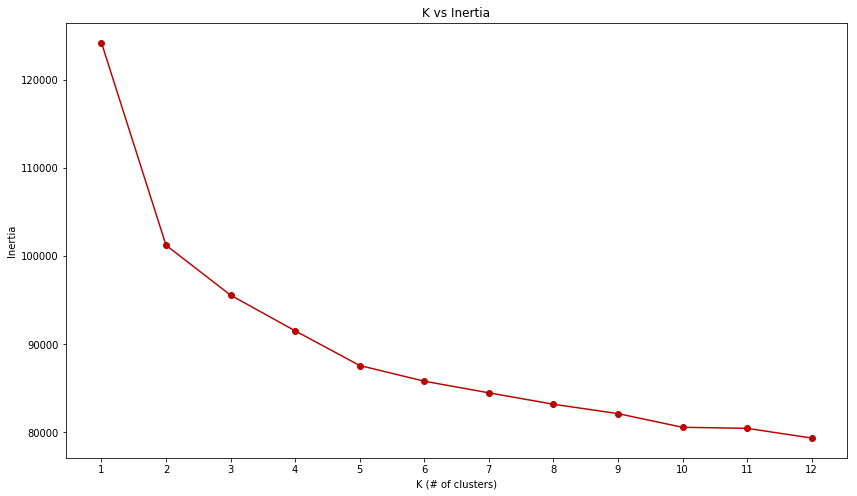

In [8]:
# iterate through Ks from 1 to 12 and append results to list
results = []
ks = range(1, 13)
for k in ks:
    # Create a KMeans instance with k clusters
    kmeans = KMeans(n_clusters=k, random_state=10)    
    # Fit model to the matrix
    kmeans.fit(categories_matrix)   
    # Append the inertia to the list of results
    results.append(kmeans.inertia_)
    
# Plot ks vs inertias
plt.figure(figsize=(14,8))
plt.plot(ks, results, '-o')
plt.title('K vs Inertia')
plt.xlabel('K (# of clusters)')
plt.ylabel('Inertia')
plt.xticks(ks)
plt.show()

I would say that the elbow is either at k=5 or k=10. Let's see how many recipes fall into each cluster when k=5 and k=10.

   cluster5
0      3093
1      6456
2      2778
3      2630
4      5095


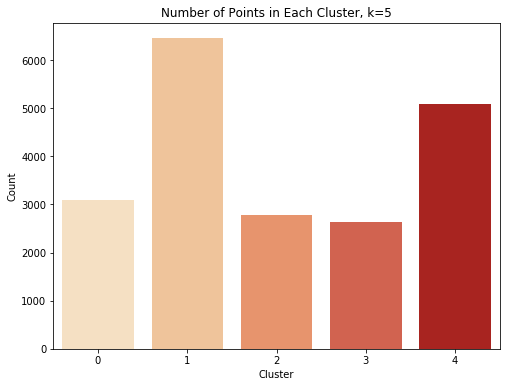

In [9]:
# computer kmeans where k=5
k_5 = 5
kmeans_5 = KMeans(n_clusters=k_5, random_state=10)
df_cats['cluster5'] = kmeans_5.fit_predict(categories_matrix)
cluster_count_5 = pd.DataFrame(df_cats['cluster5'].value_counts().sort_index())
print(cluster_count_5)

# plot bar graph of clusters and number of data points in each cluster
plt.figure(figsize=(8,6))
sns.barplot(x=cluster_count_5.index, y=cluster_count_5.cluster5, palette = 'OrRd')
plt.xticks(cluster_count_5.index)
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.title('Number of Points in Each Cluster, k=5')
plt.show()

   cluster10
0       1412
1       4871
2       1483
3       2231
4       2462
5       1679
6       1542
7        801
8       1715
9       1856


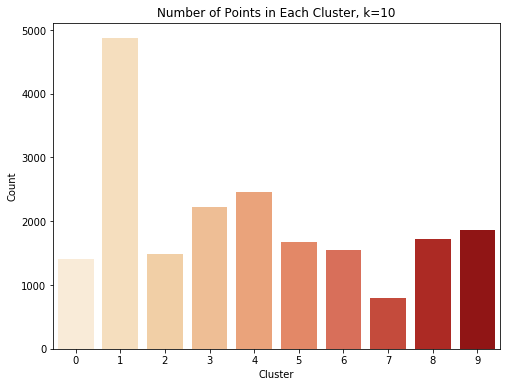

In [10]:
# computer kmeans where k=5
k_10 = 10
kmeans_10 = KMeans(n_clusters=k_10, random_state=10)
df_cats['cluster10'] = kmeans_10.fit_predict(categories_matrix)
cluster_count_10 = pd.DataFrame(df_cats['cluster10'].value_counts().sort_index())
print(cluster_count_10)

# plot bar graph of clusters and number of data points in each cluster
plt.figure(figsize=(8,6))
sns.barplot(x=cluster_count_10.index, y=cluster_count_10.cluster10, palette = 'OrRd')
plt.xticks(cluster_count_10.index)
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.title('Number of Points in Each Cluster, k=10')
plt.show()

I think that k=5 is more reasonable, but do we really want to limit how many customer segments we will have? We have a lot of categories, so it might be better to have 10 clusters. Let's check the silhouette scores for the various sizes of k.

In [11]:
# compute silhouette score for k=5
silhouette_avg_5 = silhouette_score(categories_matrix, df_cats['cluster5'])

In [12]:
# compute silhouette score for k=10
silhouette_avg_10 = silhouette_score(categories_matrix, df_cats['cluster10'])

In [13]:
print('Silhouette scores:')
print('k=5:', round(silhouette_avg_5,4))
print('k=10:', round(silhouette_avg_10,4))

Silhouette scores:
k=5: 0.0902
k=10: 0.0797


k=5 provides us with the higher silhouette score, but neither score is very high. Let's see if we can reduce our data set to only include rows where the recipe is at least categorized as a meal or part of a whole meal (e.g. appetizer or dessert). This will help us remove recipes for ingredients, such as chicken stock or salsa.

In [14]:
meals = ['Breakfast', 'Lunch', 'Brunch', 'Dinner', 'Appetizer', 'Dessert']

df_cats['Meal Sum'] = df_cats['Breakfast'] + df_cats['Lunch'] + df_cats[
                        'Brunch'] + df_cats['Dinner'] + df_cats['Appetizer'] + df_cats[
                        'Dessert']

df_cats_meals = df_cats.loc[df_cats['Meal Sum'] > 0].loc[:, :'Wisconsin']
df_cats_meals.shape

(8763, 256)

In [15]:
df_cats_meals.columns

Index(['Title', 'Rating', 'Rating Group', 'Date Time', 'Calories', 'Protein',
       'Fat', 'Sodium', '22-Minute Meals', '3-Ingredient Recipes',
       ...
       'Vegan', 'Vegetarian', 'Vermont', 'Virginia', 'Washington',
       'Washington, D.C.', 'Weelicious', 'Wheat/Gluten-Free', 'Winter',
       'Wisconsin'],
      dtype='object', length=256)

We've reduced our data set down to only 8,763 rows. Let's rerun the K-Means algorithm to see what results we get.

In [16]:
# transform binary category columns into a matrix
categories_matrix_meals = np.matrix(df_cats_meals.as_matrix())[:,8:]
categories_matrix_meals.shape

(8763, 248)

In [17]:
categories_matrix_meals

matrix([[0.0, 0.0, 0.0, ..., 0.0, 0.0, 0.0],
        [0.0, 0.0, 0.0, ..., 1.0, 0.0, 0.0],
        [0.0, 0.0, 0.0, ..., 0.0, 0.0, 0.0],
        ..., 
        [0.0, 0.0, 0.0, ..., 0.0, 0.0, 0.0],
        [0.0, 0.0, 0.0, ..., 1.0, 0.0, 0.0],
        [0.0, 0.0, 0.0, ..., 0.0, 0.0, 0.0]], dtype=object)

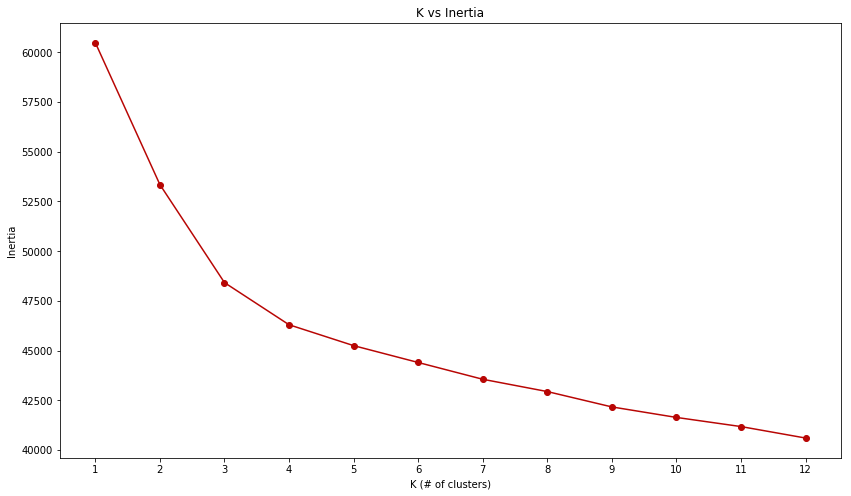

In [18]:
# iterate through Ks from 1 to 12 and append results to list
results_meals = []
for k in ks:
    # Create a KMeans instance with k clusters
    kmeans = KMeans(n_clusters=k, random_state=10)    
    # Fit model to the matrix
    kmeans.fit(categories_matrix_meals)   
    # Append the inertia to the list of results
    results_meals.append(kmeans.inertia_)
    
# Plot ks vs inertias
plt.figure(figsize=(14,8))
plt.plot(ks, results_meals, '-o')
plt.title('K vs Inertia')
plt.xlabel('K (# of clusters)')
plt.ylabel('Inertia')
plt.xticks(ks)
plt.show()

It looks like the elbow in the graph is around k=4. Let's compute the silhouette scores to see if we're getting better results with this extract of data.

In [19]:
# initiate dictionary and range for for loop
avg_s_scores_meals = {}
range_n_clusters = range(2,13)

# test various sizes of k and save corresponding silhouette score
for k in range_n_clusters:

    # Initialize the clusterer with k value and a random generator
    clusterer = KMeans(n_clusters=k, random_state=10)    
    cluster_labels = clusterer.fit_predict(categories_matrix_meals)   
    
    # compute silhouette score
    silhouette_avg = silhouette_score(categories_matrix_meals, cluster_labels)
    avg_s_scores_meals[k] = silhouette_avg

In [20]:
# print all scores from dictionary
for key, value in avg_s_scores_meals.items():
    print('k =', key, ':', round(value,4))

k = 2 : 0.119
k = 3 : 0.1272
k = 4 : 0.1215
k = 5 : 0.1022
k = 6 : 0.113
k = 7 : 0.0789
k = 8 : 0.0632
k = 9 : 0.0636
k = 10 : 0.0628
k = 11 : 0.0574
k = 12 : 0.0684


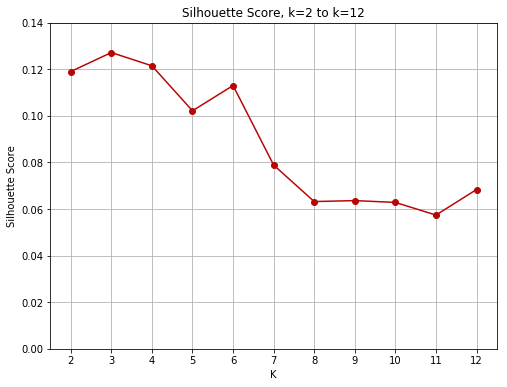

In [21]:
# plot silhouette score for each k
x, y = zip(*sorted(avg_s_scores_meals.items()))
plt.figure(figsize=(8,6))
plt.plot(x, y, '-o')
plt.xticks(range_n_clusters)
plt.yticks([0, .02, .04, .06, .08, .10, .12, .14])
plt.xlabel('K')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score, k=2 to k=12')
plt.grid(True)
plt.show()

We've ended up with higher silhouette scores than before! And k=3 for our meal dataset results in the maximum silhouette score. But is this too few clusters for the segmentation? I think that k=6 is a more appropriate number of clusters. Let's check to see how the clusters are distributed for k=3 and k=6.

   cluster3
0      3538
1      2209
2      3016


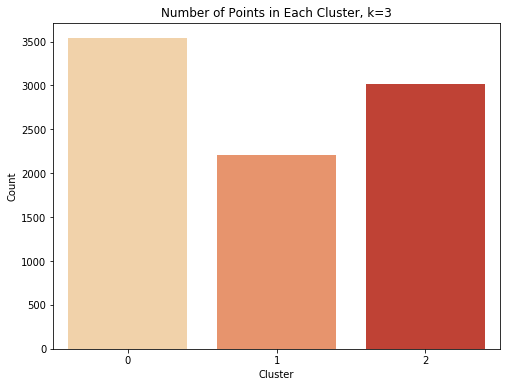

In [22]:
# computer kmeans where k=3
k_3 = 3
kmeans_3 = KMeans(n_clusters=k_3, random_state=10)
df_cats_meals['cluster3'] = kmeans_3.fit_predict(categories_matrix_meals)
cluster_count_3 = pd.DataFrame(df_cats_meals['cluster3'].value_counts().sort_index())
print(cluster_count_3)

# plot bar graph of clusters and number of data points in each cluster
plt.figure(figsize=(8,6))
sns.barplot(x=cluster_count_3.index, y=cluster_count_3.cluster3, palette = 'OrRd')
plt.xticks(cluster_count_3.index)
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.title('Number of Points in Each Cluster, k=3')
plt.show()

   cluster6
0      1142
1      1344
2      1299
3      2149
4      2096
5       733


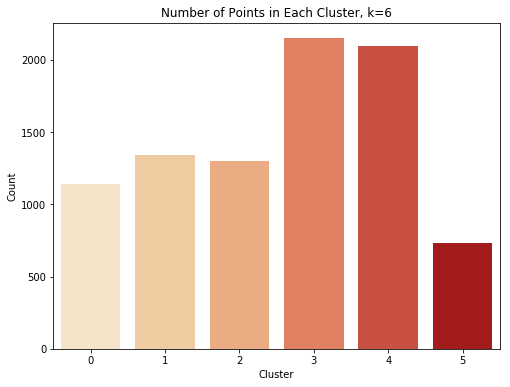

In [23]:
# computer kmeans where k=6
k_6 = 6
kmeans_6 = KMeans(n_clusters=k_6, random_state=10)
df_cats_meals['cluster6'] = kmeans_6.fit_predict(categories_matrix_meals)
cluster_count_6 = pd.DataFrame(df_cats_meals['cluster6'].value_counts().sort_index())
print(cluster_count_6)

# plot bar graph of clusters and number of data points in each cluster
plt.figure(figsize=(8,6))
sns.barplot(x=cluster_count_6.index, y=cluster_count_6.cluster6, palette = 'OrRd')
plt.xticks(cluster_count_6.index)
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.title('Number of Points in Each Cluster, k=6')
plt.show()

My biggest concern for k=6 is that each cluster just contains one of our meal types (e.g. Breakfast or Dinner). If this ends up being the case, we may have to try reducing our data set to just be one type of meal.

In [24]:
# k=6, cluster=0
df_cats_meals.loc[df_cats_meals['cluster6'] == 0].head(20)[[
    'Title','Breakfast', 'Lunch', 'Brunch', 'Dinner', 'Appetizer', 'Dessert', 'cluster6']]

,Title,Breakfast,Lunch,Brunch,Dinner,Appetizer,Dessert,cluster6
34,Fontina Mac with Squash and Sage,0.0,1.0,0.0,1.0,0.0,0.0,0
47,Herbed Goat Cheese Spread with Mint,0.0,0.0,0.0,1.0,1.0,0.0,0
61,"Romaine, Grilled Avocado, and Smoky Corn Salad...",0.0,1.0,0.0,0.0,0.0,0.0,0
66,Scarborough Fair Tofu Burger,0.0,1.0,0.0,1.0,0.0,0.0,0
70,"Roasted Butternut Squash, Rosemary, and Garlic...",0.0,0.0,0.0,1.0,0.0,0.0,0
89,Ricotta Omelets,1.0,0.0,1.0,0.0,0.0,0.0,0
128,Spicy Sesame Noodles with Chopped Peanuts and ...,0.0,0.0,0.0,1.0,0.0,0.0,0
133,Radishes with Burrata,0.0,1.0,0.0,0.0,0.0,0.0,0
150,Jalapeño-Cheddar Frittata,0.0,0.0,1.0,0.0,1.0,0.0,0
151,Roasted Beets and Citrus with Feta,0.0,0.0,0.0,1.0,1.0,0.0,0


In [25]:
# k=6, cluster=1
df_cats_meals.loc[df_cats_meals['cluster6'] == 1].head(20)[[
    'Title','Breakfast', 'Lunch', 'Brunch', 'Dinner', 'Appetizer', 'Dessert', 'cluster6']]

,Title,Breakfast,Lunch,Brunch,Dinner,Appetizer,Dessert,cluster6
35,Aztec Chicken,0.0,0.0,0.0,1.0,0.0,0.0,1
43,Purple-Potato and Crab Gratin,0.0,1.0,0.0,0.0,0.0,0.0,1
53,Pancetta Roast Chicken with Walnut Stuffing,0.0,0.0,0.0,1.0,0.0,0.0,1
102,Parsnip and Apple Soup,0.0,0.0,0.0,0.0,1.0,0.0,1
103,Short Rib Pot Pie,0.0,0.0,0.0,1.0,0.0,0.0,1
146,Sage-Roasted Turkey with Caramelized Onions an...,0.0,0.0,0.0,1.0,0.0,0.0,1
147,Shrimp Cakes with Andouille Sausage,0.0,1.0,0.0,0.0,1.0,0.0,1
155,"Sauteed Veal with Shrimp, Mushroom, and Brandy...",0.0,0.0,0.0,1.0,0.0,0.0,1
170,Red Wine Brasato with Glazed Root Vegetables,0.0,0.0,0.0,1.0,0.0,0.0,1
178,Baked Beans with Slab Bacon and Breadcrumbs,0.0,0.0,0.0,1.0,0.0,0.0,1


In [26]:
# k=6, cluster=2
df_cats_meals.loc[df_cats_meals['cluster6'] == 2].head(20)[[
    'Title','Breakfast', 'Lunch', 'Brunch', 'Dinner', 'Appetizer', 'Dessert', 'cluster6']]

,Title,Breakfast,Lunch,Brunch,Dinner,Appetizer,Dessert,cluster6
3,Mahi-Mahi in Tomato Olive Sauce,0.0,0.0,0.0,1.0,0.0,0.0,2
9,Ham Persillade with Mustard Potato Salad and M...,0.0,1.0,0.0,0.0,0.0,0.0,2
19,"Tuna, Asparagus, and New Potato Salad with Chi...",0.0,1.0,0.0,0.0,0.0,0.0,2
30,Asian Steak Topped with Bell Pepper Stir-Fry,0.0,0.0,0.0,1.0,0.0,0.0,2
36,Pastry Twists with Spiced Sugar-Honey Glaze,0.0,0.0,0.0,0.0,0.0,1.0,2
44,"Grilled Beef, Jícama, and Apple Salad",0.0,0.0,0.0,1.0,0.0,0.0,2
50,Mexican Chile and Mushroom Soup,0.0,1.0,0.0,0.0,0.0,0.0,2
52,Braised Chicken With Artichokes and Olives,0.0,0.0,0.0,1.0,0.0,0.0,2
55,Collard-and-Prosciutto Chicken Roulades Over W...,0.0,0.0,0.0,1.0,0.0,0.0,2
80,"Braised Chicken and Rice with Orange, Saffron,...",0.0,0.0,0.0,1.0,0.0,0.0,2


In [27]:
# k=6, cluster=3
df_cats_meals.loc[df_cats_meals['cluster6'] == 3].head(20)[[
    'Title','Breakfast', 'Lunch', 'Brunch', 'Dinner', 'Appetizer', 'Dessert', 'cluster6']]

,Title,Breakfast,Lunch,Brunch,Dinner,Appetizer,Dessert,cluster6
11,Spicy Noodle Soup,1.0,0.0,0.0,0.0,0.0,0.0,3
22,Fish Fillets in Parchment with Asparagus and O...,0.0,0.0,0.0,1.0,0.0,0.0,3
23,Pancetta and Taleggio Lasagna with Treviso,0.0,0.0,0.0,1.0,0.0,0.0,3
51,Peanut Butter-Banana Muffins,1.0,0.0,1.0,0.0,0.0,0.0,3
54,1977 Coconut Angel Food Cake,0.0,0.0,0.0,0.0,0.0,1.0,3
76,South American-Style Jícama and Orange Salad,0.0,0.0,0.0,0.0,1.0,0.0,3
78,Maple Pumpkin Pots de Crème,0.0,0.0,0.0,0.0,0.0,1.0,3
86,Bacon Crackers,0.0,0.0,0.0,0.0,1.0,0.0,3
87,Roast Chicken With Sorghum and Squash,0.0,0.0,0.0,1.0,0.0,0.0,3
97,Roast Beef Salad with Cabbage and Horseradish,0.0,1.0,0.0,0.0,0.0,0.0,3


In [28]:
# k=6, cluster=4
df_cats_meals.loc[df_cats_meals['cluster6'] == 4].head(20)[[
    'Title','Breakfast', 'Lunch', 'Brunch', 'Dinner', 'Appetizer', 'Dessert', 'cluster6']]

,Title,Breakfast,Lunch,Brunch,Dinner,Appetizer,Dessert,cluster6
12,Banana-Chocolate Chip Cake With Peanut Butter ...,0.0,0.0,0.0,0.0,0.0,1.0,4
16,Sweet Buttermilk Spoon Breads,1.0,0.0,1.0,0.0,0.0,1.0,4
29,Apricot-Cherry Shortcakes,0.0,0.0,0.0,0.0,0.0,1.0,4
40,Coconut-Key Lime Sheet Cake,0.0,0.0,0.0,0.0,0.0,1.0,4
57,Pumpkin Muffins,1.0,0.0,1.0,0.0,0.0,0.0,4
64,Mixed Berry Pavlovas,0.0,0.0,0.0,0.0,0.0,1.0,4
65,Orange-Almond Cake with Chocolate Icing,0.0,0.0,0.0,0.0,0.0,1.0,4
68,White Chocolate Tartlets with Strawberries and...,0.0,0.0,0.0,0.0,0.0,1.0,4
72,Pear-Hazelnut Cheesecakes with Pear-Raspberry ...,0.0,0.0,0.0,0.0,0.0,1.0,4
75,Banana Layer Cake with Cream Cheese Frosting,0.0,0.0,0.0,0.0,0.0,1.0,4


In [29]:
# k=6, cluster=5
df_cats_meals.loc[df_cats_meals['cluster6'] == 5].head(20)[[
    'Title','Breakfast', 'Lunch', 'Brunch', 'Dinner', 'Appetizer', 'Dessert', 'cluster6']]

,Title,Breakfast,Lunch,Brunch,Dinner,Appetizer,Dessert,cluster6
26,Cucumber-Basil Egg Salad,0.0,1.0,0.0,1.0,0.0,0.0,5
49,Citrus Salad with Mint Sugar,1.0,0.0,1.0,0.0,0.0,0.0,5
114,"Cranberry, Quince, and Pearl Onion Compote",1.0,0.0,0.0,0.0,0.0,0.0,5
148,Creamy Tofu Salad,0.0,1.0,0.0,0.0,0.0,0.0,5
172,Egg Salad with Lemon and Fennel,0.0,0.0,0.0,1.0,0.0,0.0,5
196,Lemon-Parsley Linguine,0.0,0.0,0.0,1.0,0.0,0.0,5
229,Blackberry-Raspberry Sauce,0.0,0.0,0.0,0.0,0.0,1.0,5
242,"Frisée, Radicchio, and Asian Pear Salad with H...",0.0,1.0,0.0,0.0,0.0,0.0,5
271,Breakfast Bowl With Quinoa and Berries,1.0,0.0,0.0,0.0,0.0,0.0,5
295,Florida Ambrosia Salad,0.0,0.0,0.0,0.0,0.0,1.0,5


I think that these clusters could be a little more clear cut. Let's see what happens when we specify meal categories on the dataframe that contains but categories and ingredients.

In [85]:
df_full['Meal Sum'] = df_full['Breakfast'] + df_full['Lunch'] + df_full[
                        'Brunch'] + df_full['Dinner'] + df_full['Appetizer'] + df_full[
                        'Dessert']

df_full_meals = df_full.loc[df_full['Meal Sum'] > 0].loc[:, '22-Minute Meals':'Zucchini']

# our Fat and Sodium columns are getting pulled in incorrectly
# we have enough categories, so simply remove them
df_full_meals.drop('Fat.1', axis=1, inplace=True)
df_full_meals.drop('Sodium.1', axis=1, inplace=True)

df_full_meals.shape

(8763, 587)

In [86]:
# transform binary category columns into a matrix
full_matrix_meals = np.matrix(df_full_meals.as_matrix())[:,8:]
full_matrix_meals.shape

(8763, 579)

In [87]:
full_matrix_meals

matrix([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ..., 
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [88]:
for i, row in df_full_meals.iterrows():
    for j in row.index:
        if row[j] > 1:
            print(i, j, row[j])

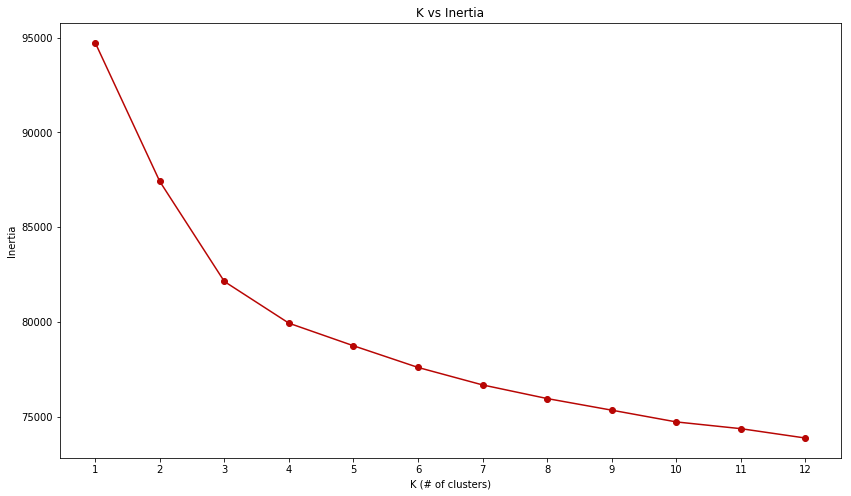

In [89]:
# iterate through Ks from 1 to 12 and append results to list
results_full_meals = []
for k in ks:
    # Create a KMeans instance with k clusters
    kmeans = KMeans(n_clusters=k, random_state=10)    
    # Fit model to the matrix
    kmeans.fit(full_matrix_meals)   
    # Append the inertia to the list of results
    results_full_meals.append(kmeans.inertia_)
    
# Plot ks vs inertias
plt.figure(figsize=(14,8))
plt.plot(ks, results_full_meals, '-o')
plt.title('K vs Inertia')
plt.xlabel('K (# of clusters)')
plt.ylabel('Inertia')
plt.xticks(ks)
plt.show()

The elbow again seems to be at k=4, and no other number of clusters stands out to me.

In [90]:
# initiate dictionary and range for for loop
avg_s_scores_full_meals = {}

# test various sizes of k and save corresponding silhouette score
for k in range_n_clusters:

    # Initialize the clusterer with k value and a random generator
    clusterer = KMeans(n_clusters=k, random_state=10)    
    cluster_labels = clusterer.fit_predict(full_matrix_meals)   
    
    # compute silhouette score
    silhouette_avg = silhouette_score(full_matrix_meals, cluster_labels)
    avg_s_scores_full_meals[k] = silhouette_avg

In [91]:
# print all scores from dictionary
for key, value in avg_s_scores_full_meals.items():
    print('k =', key, ':', round(value,4))

k = 2 : 0.0776
k = 3 : 0.0799
k = 4 : 0.0772
k = 5 : 0.0594
k = 6 : 0.0446
k = 7 : 0.0438
k = 8 : 0.0382
k = 9 : 0.0383
k = 10 : 0.0394
k = 11 : 0.0285
k = 12 : 0.0343


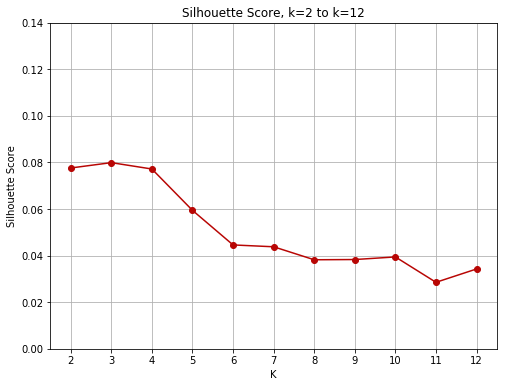

In [92]:
# plot silhouette score for each k
x, y = zip(*sorted(avg_s_scores_full_meals.items()))
plt.figure(figsize=(8,6))
plt.plot(x, y, '-o')
plt.xticks(range_n_clusters)
plt.yticks([0, .02, .04, .06, .08, .10, .12, .14])
plt.xlabel('K')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score, k=2 to k=12')
plt.grid(True)
plt.show()

Adding the ingredient columns to our dataset worsened our results. So far k=3 for our meal specified categories givees us the highest silhouette score. But perhaps we can get better results from a different algorithm. K-means is meant to provide us with a low number of clusters usually, so maybe we'll get better results from an algorithm that's meant to provide us with more clusters. Considering that we have so much data, I think that this could work out well. I also think that we should keep only including rows that have at least one meal tag, since it has so far provided us with the best results in the K-Means algorithm.

# DBScan